## Load Experiment Data

In [1]:
# Load the policy
import os
import pandas
from garage.experiment import Snapshotter
import pandas as pd
EXPERIMENT_NAME = "CL_point_env_17" #13
experiment_dir = os.path.join("data/local/experiment", EXPERIMENT_NAME)
snapshotter = Snapshotter()
data = snapshotter.load(experiment_dir)
policy = data['algo'].policy

# You can also access other components of the experiment
env = data['env']

progress_csv_path = os.path.join(experiment_dir, 'progress.csv')
# progress_df = pd.read_csv(progress_csv_path)

2025-01-08 17:27:08.820997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(


In [2]:
num_train_tasks=2
from garage.experiment.task_sampler import SetTaskSampler
from garage.envs import GymEnv, normalize
from garage.envs.point_env import PointEnv
from garage.torch.algos.CLMeta import PEARLWorker

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env))
env = env_sampler.sample(num_train_tasks)

In [25]:
from garage.experiment.meta_evaluator import MetaEvaluator

meta_evaluator = MetaEvaluator(test_tasks=env,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=2,
                               return_task_embeddings=True,
                               log_wandb=False)

trajs, task_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




Text(0.5, 1.0, 'Trajectories of Task 1 and Task 2')

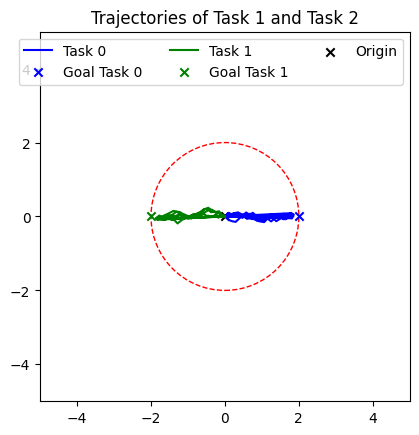

In [4]:


import matplotlib.pyplot as plt
plt.gca().set_aspect('equal', adjustable='box')
circle = plt.Circle((0, 0), 2, color='r', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx_task, task_traj in enumerate(trajs):
    plt.plot(task_traj.observations[:,0], task_traj.observations[:,1], label=f"Task {idx_task}", color=colors[idx_task])
    plt.scatter(task_traj.env_infos["task"][0]["goal"][0], task_traj.env_infos["task"][0]["goal"][1], color=colors[idx_task], marker='x', label=f'Goal Task {idx_task}')
plt.scatter(0, 0, color='black', marker='x', label='Origin')
plt.legend(ncol=3)
plt.title("Trajectories of Task 1 and Task 2")

# Generalization Performance

In [23]:
num_test_tasks=5

worker_args = dict(deterministic=True, accum_context=True)
env_sampler = SetTaskSampler(
    PointEnv,
    wrapper=lambda env, _: normalize(
        env))
test_envs = env_sampler.sample(num_test_tasks)

meta_evaluator = MetaEvaluator(test_tasks=test_envs,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=5,
                               return_task_embeddings=True,
                               log_wandb=False)

test_trajs, test_task_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'garage.torch.distributions.tanh_normal.TanhNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/Users/paulnitschke/Desktop/projects/geo_meta_rl/garage/_dtypes.py:1051: UserWarning: Observation array([0., 0., 2.]) is outside observation_space Box(-inf, inf, (3,), float32)
  warnings.warn(


Text(0.5, 1.0, 'Trajectories of Task 1 and Task 2')

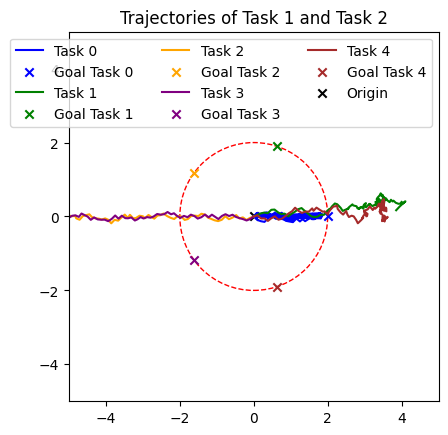

In [24]:
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal', adjustable='box')
circle = plt.Circle((0, 0), 2, color='r', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx_task, task_traj in enumerate(test_trajs):
    plt.plot(task_traj.observations[:,0], task_traj.observations[:,1], label=f"Task {idx_task}", color=colors[idx_task])
    plt.scatter(task_traj.env_infos["task"][0]["goal"][0], task_traj.env_infos["task"][0]["goal"][1], color=colors[idx_task], marker='x', label=f'Goal Task {idx_task}')
plt.scatter(0, 0, color='black', marker='x', label='Origin')
plt.legend(ncol=3)
plt.title("Trajectories of Task 1 and Task 2")

# How well do test-tasks do with correct, hard-coded embedding?

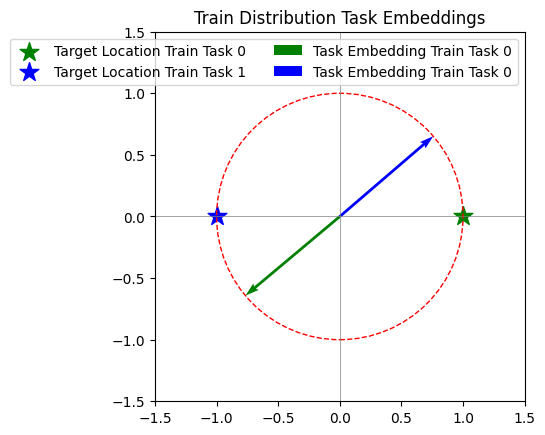

In [26]:
import numpy as np

# Extract the vectors from task_embeddings
train_task_1_embedding = task_embeddings[0][0]
train_task_2_embedding = task_embeddings[1][0]

plt.scatter(1, 0, color='green', marker='*', s=200, label='Target Location Train Task 0')
plt.scatter(-1, 0, color='blue', marker='*', s=200, label='Target Location Train Task 1')
plt.quiver(0, 0, train_task_1_embedding[0], train_task_1_embedding[1], angles='xy', scale_units='xy', scale=1, color='green', label='Task Embedding Train Task 0')
plt.quiver(0, 0, train_task_2_embedding[0], train_task_2_embedding[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Task Embedding Train Task 0')
unit_circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

# Set the aspect of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.legend(ncols=2, loc="best")
plt.title("Train Distribution Task Embeddings")
plt.show()



In [8]:
import numpy as np

import numpy as np

def compute_angle(p1, p2):
    """
    Computes the angle in radians to rotate point p1 to point p2 on the unit circle.

    Parameters:
    - p1: numpy array of shape (2,), coordinates of the first point on the unit circle.
    - p2: numpy array of shape (2,), coordinates of the second point on the unit circle.

    Returns:
    - angle: float, the signed angle in radians.
    """
    # Compute dot product and determinant
    dot = np.dot(p1, p2)
    det = np.linalg.det(np.array([p1, p2]))

    # Calculate the angle using arctan2
    angle = np.arctan2(det, dot)

    return angle

def rotate_point(p, angle):
    """
    Rotates a point on the unit circle by a given angle.

    Parameters:
    - p: numpy array of shape (2,), coordinates of the point on the unit circle.
    - angle: float, the angle in radians to rotate the point.

    Returns:
    - rotated_p: numpy array of shape (2,), the rotated point coordinates.
    """
    # Rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Apply the rotation matrix
    rotated_p = np.dot(rotation_matrix, p)

    return rotated_p



# Example usage
p1 = (1,0)
p2 = (train_task_1_embedding[0], train_task_1_embedding[1])

# Compute the angle to rotate p1 to p2
angle = compute_angle(p1, p2)
print(f"The angle to rotate {p1} to {p2} is {angle} radians.")

# Rotate p1 by the computed angle
rotated_p1 = rotate_point(p1, angle)
print(f"Rotating {p1} by {angle} radians gives {rotated_p1}.")

The angle to rotate (1, 0) to (-0.76634437, -0.64243007) is -2.4439276346218755 radians.
Rotating (1, 0) by -2.4439276346218755 radians gives [-0.76634434 -0.64243004].


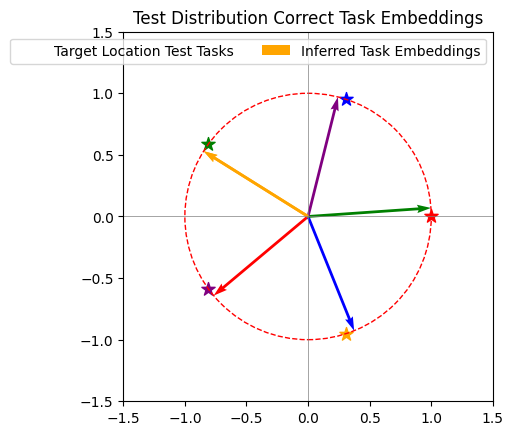

In [27]:
inferred_embeddings=[]
test_goal_positions = [test_envs[i]._make_env().reset()[1] for i in range(num_test_tasks)]

colors = ['red', 'blue', 'green', 'purple', 'orange']
for idx_test_goal_position, test_goal_position in enumerate(test_goal_positions):
    test_goal_position["goal"] = test_goal_position["goal"] / np.linalg.norm(test_goal_position["goal"])
    inferred_embedding = rotate_point(test_goal_position["goal"], angle)
    inferred_embeddings.append(inferred_embedding)
    plt.scatter(test_goal_position["goal"][0], test_goal_position["goal"][1], marker='*', s=100, color=colors[idx_test_goal_position])
    plt.quiver(0, 0, inferred_embedding[0], inferred_embedding[1], angles='xy', scale_units='xy', scale=1, color=colors[idx_test_goal_position])

plt.scatter(test_goal_position["goal"][0], test_goal_position["goal"][1], marker='*', s=0, label="Target Location Test Tasks")
plt.quiver(0, 0, inferred_embedding[0], inferred_embedding[1], angles='xy', scale_units='xy', scale=1, color=colors[idx_test_goal_position], label="Inferred Task Embeddings")


unit_circle = plt.Circle((0, 0), 1, color='r', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)

# Set the aspect of the plot to be equal
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.legend(ncols=2, loc="best")
plt.title("Test Distribution Correct Task Embeddings")
plt.show()

In [28]:
from garage.experiment.meta_evaluator import MetaEvaluator
import torch

# BEGIN: Convert numpy arrays to pytorch tensors
inferred_embeddings = [torch.tensor(embedding) for embedding in inferred_embeddings]
# END:

meta_evaluator = MetaEvaluator(test_tasks=test_envs,
                               worker_class=PEARLWorker,
                               worker_args=worker_args,
                               n_exploration_eps=10,
                               n_test_tasks=5,
                               return_task_embeddings=True,
                               log_wandb=False,
                               hard_coded_embeddings=inferred_embeddings)

hard_coded_embedding_trajs, check_embeddings = meta_evaluator.evaluate(algo=data['algo'])



Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




Text(0.5, 1.0, 'Trajectories of Task 1 and Task 2')

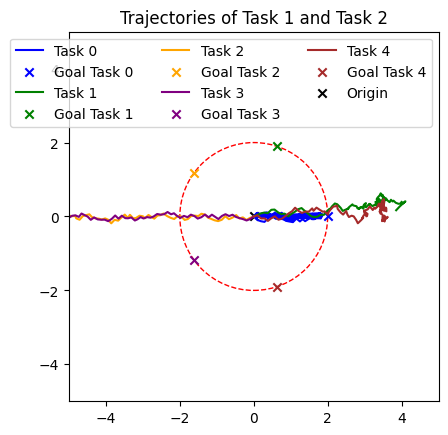

In [29]:
import matplotlib.pyplot as plt
plt.gca().set_aspect('equal', adjustable='box')
circle = plt.Circle((0, 0), 2, color='r', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
colors = ['blue', 'green', 'orange', 'purple', 'brown']
for idx_task, task_traj in enumerate(hard_coded_embedding_trajs):
    plt.plot(task_traj.observations[:,0], task_traj.observations[:,1], label=f"Task {idx_task}", color=colors[idx_task])
    plt.scatter(task_traj.env_infos["task"][0]["goal"][0], task_traj.env_infos["task"][0]["goal"][1], color=colors[idx_task], marker='x', label=f'Goal Task {idx_task}')
plt.scatter(0, 0, color='black', marker='x', label='Origin')
plt.legend(ncol=3)
plt.title("Trajectories of Task 1 and Task 2")